In [1]:
indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/somatic_variants/gatk_mutect/peaks_atac_peaks/"
vars_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/somatic_variants/regions_atac_peaks/gatk_mutect/post/variants.annotate.gene.vcf"
cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/cells_meta.tsv"
dendro_indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/barcodes/btwnClones_dendro_dt_0.6"

outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/somatic_variants/gatk_mutect/peaks_atac_peaks/filt_chip/som_dendro_0.6"


chip_genes_f = "/data/Mito_Trace/output/geneRegions/gff_A2/chip_genes.bed"
n_cpu=24

In [2]:
from src.utils.data_io import read_csv_multichar
import mplh.cluster_help as ch
import mplh.fig_utils as fu

fig_utils from mplh


In [3]:
from glob import glob
from os.path import basename, join
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
%load_ext autoreload
%autoreload 2
import numpy as np

from pandarallel import pandarallel
pandarallel.initialize(n_cpu)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
#outdir = join(indir, "som_dendro")

In [5]:
import src.utils.dendro_clust as dc

In [6]:
chip_df = pd.read_csv(chip_genes_f,sep="\t", header=None)
cols = chip_df.columns.astype("object").values 
cols[:6] = ["chr", "start", "end", "name","score","strand"]
chip_df.columns = cols
chip_df

,chr,start,end,name,score,strand,6,7,8,9,10
0,chr1,43332848,43357772,.,.,+,HAVANA,gene,.,"gene_id ""ENSG00000117400""; gene_version ""17""; ...",True
1,chr11,119201275,119318926,.,.,+,HAVANA,gene,.,"gene_id ""ENSG00000110395""; gene_version ""6""; g...",True
2,chr15,90078044,90107504,.,.,-,HAVANA,gene,.,"gene_id ""ENSG00000182054""; gene_version ""9""; g...",True
3,chr17,7656778,7692550,.,.,-,HAVANA,gene,.,"gene_id ""ENSG00000141510""; gene_version ""17""; ...",True
4,chr17,76729114,76742374,.,.,-,HAVANA,gene,.,"gene_id ""ENSG00000161547""; gene_version ""16""; ...",True
5,chr2,25222854,25347590,.,.,-,HAVANA,gene,.,"gene_id ""ENSG00000119772""; gene_version ""16""; ...",True
6,chr2,197383514,197440091,.,.,-,HAVANA,gene,.,"gene_id ""ENSG00000115524""; gene_version ""16""; ...",True
7,chr2,208231226,208271074,.,.,-,HAVANA,gene,.,"gene_id ""ENSG00000138413""; gene_version ""13""; ...",True
8,chr20,32353329,32444319,.,.,+,HAVANA,gene,.,"gene_id ""ENSG00000171456""; gene_version ""19""; ...",True
9,chr21,43087955,43112587,.,.,-,HAVANA,gene,.,"gene_id ""ENSG00000160201""; gene_version ""11""; ...",True


In [7]:
cells_meta = pd.read_csv(cells_meta_f, sep='\t')
cells_meta.head()
cells_meta["clone"] = cells_meta.apply(lambda x: f"{x['donor']}_{x['lineage']}",axis=1)
cells_meta["ID"] = cells_meta.apply(lambda x: f"{x['ID']}_{x['donor']}",axis=1)
cells_meta
cells_meta["lineage"]=cells_meta["clone"]

## Load dendro labels and barcodes mean af

#### Get dendro cluster and mean af for each donor and concat

In [8]:
donors = cells_meta["donor"].unique()
conditions = cells_meta["condition"].unique()

clones = []
mean_af = []
for d in donors:
    clones.append(pd.read_csv(join(dendro_indir, f"donor{d}.clones_dendro.csv"), index_col=0))
    clones[-1]["den_clust"] = str(d) + "_" + clones[-1]["den_clust"] 
    mean_af.append(pd.read_csv(join(dendro_indir, f"donor{d}.mean.csv"), index_col=0))
clones = pd.concat(clones)

mean_af = pd.concat(mean_af, axis=0, ignore_index=False).fillna(0)
mean_af

,310C,146C,750G,15326G,8860G,2706G,14766T,16126C,1438G,7028T,...,3244A,16129A,2623G,15497A,15297C,5442C,14674C,8743A,11812G,4917G
lineage,,,,,,,,,,,,,,,,,,,,,
0_10,0.002455,0.893517,0.971954,0.982927,0.975429,0.978528,0.984444,0.974246,0.923313,0.937051,...,0.004847,0.003067,0.006074,0.000192,0.000000,0.000000,0.003736,0.004218,0.011260,0.014761
0_14,0.000887,0.873655,0.988000,0.979600,0.988000,0.967250,0.972000,0.966170,0.978606,0.947318,...,0.005754,0.000000,0.001600,0.000000,0.000000,0.000000,0.000000,0.000000,0.010513,0.005211
0_22,0.864224,0.973236,0.993310,0.998796,0.986688,0.974026,0.986747,0.993419,0.993462,0.986603,...,0.000235,0.013781,0.000418,0.000000,0.000000,0.000000,0.004329,0.011567,0.007070,0.010021
0_4,0.836895,0.439123,0.961538,0.980090,0.966252,0.975198,0.961183,0.950206,0.922975,0.897354,...,0.005630,0.003083,0.002011,0.000000,0.000000,0.000000,0.014691,0.011905,0.016556,0.013753
0_19,0.854155,0.955079,0.994283,0.999257,0.994831,0.984163,0.989826,0.999586,0.989671,0.988385,...,0.003251,0.004132,0.005124,0.000000,0.000154,0.000000,0.000315,0.001535,0.008909,0.007391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1_17,0.901413,0.005867,0.999752,0.999733,0.999626,0.999912,0.999792,0.999871,0.994541,0.999027,...,0.000540,0.000190,0.000000,0.000000,0.002469,0.000147,0.000491,0.000101,0.990786,0.986095
1_19,0.901414,0.007378,0.999794,0.991460,0.993255,0.999821,0.999892,0.999934,1.000000,0.993793,...,0.016367,0.000799,0.001692,0.000000,0.000000,0.011299,0.000000,0.000000,0.988182,0.985471
1_6,0.987297,0.004358,0.994849,0.999830,0.999444,0.995711,0.999304,0.996613,0.991720,0.992149,...,0.000674,0.009607,0.003219,0.000000,0.001223,0.010808,0.000333,0.000054,0.993072,0.991698


## Load the somatic variants number of cells and merge across conditions

In [9]:
clone_som_d = {}
clone_som_vars_d = {}

for c in conditions:
    try:
        print('condition', c)
        clone_som_d[c] = pd.read_csv(join(indir, c, "clones_alt_numCells.csv"), index_col=0)
        clone_som_vars_d[c] = pd.read_csv(join(indir, c, "clone_alt_numCells.variants.tsv"), sep="\t")
        clone_som_d[c]["condition"] = c
        clone_som_d[c]["name"] = clone_som_d[c].index
    except:
        print(f"{c} not here")
clone_som_df = pd.concat(clone_som_d, axis=0).reset_index(drop=True).fillna(0)
clone_som_merge_df = clone_som_df.drop("condition",axis=1).groupby("name").agg(sum).astype(int)
clone_som_merge_df



## Process the variants 
clone_som_vars_df = pd.concat(clone_som_vars_d) #[conditions[0]].reset_index()
# for c in conditions[1:]:
#     clone_som_vars_df = pd.merge(clone_som_vars_df, clone_som_vars_d[c].reset_index(), how="outer" ) #, left_index=True, right_index=True, 
clone_som_vars_df = clone_som_vars_df.drop_duplicates().set_index("var")

clone_som_vars_df["Gene Name"] = clone_som_vars_df["Gene Name"].fillna("")
clone_som_vars_df["Gene Name"] = clone_som_vars_df.apply(lambda x: x["Gene"] if x['Gene Name']=="" else x['Gene Name'] , axis=1)


def add_chr_pos(x):
    spl = x.name.split("_")
    return [spl[0], spl[1]]
clone_som_vars_df[["chr", "pos"]] = clone_som_vars_df.parallel_apply(add_chr_pos , axis=1, result_type="expand")
clone_som_vars_df["pos"] =  clone_som_vars_df["pos"].astype(int)


condition Control
condition Flt3l
condition Input


## filter for variants in chip gene regions

In [10]:
def is_chip_gene(chip_gene, curr_var ):
    if (curr_var["chr"] == chip_gene["chr"]):
        if (chip_gene["strand"] == "+"):
            if curr_var["pos"]>=chip_gene["start"] & curr_var["pos"]<=chip_gene["end"]:
                return True    
        elif (chip_gene["strand"] == "-"):
            if curr_var["pos"]<=chip_gene["start"] & curr_var["pos"]>=chip_gene["end"]:
                return True
        else: 
            print("No strand on gene. Returning False")
    return False

def is_in_any_chip_gene(curr_var, chip_bed):
    for ind, curr_gene in chip_bed.iterrows():
        #print('curr_gene')
        #print(curr_gene)
        if is_chip_gene(curr_gene, curr_var):
            return True
    return False

clone_som_vars_df["is_chip"] = clone_som_vars_df.parallel_apply(is_in_any_chip_gene, args=(chip_df,), axis=1)


In [11]:
clone_som_vars_df = clone_som_vars_df[clone_som_vars_df["is_chip"]]

In [12]:
clone_som_vars_df = clone_som_vars_df.reset_index().drop_duplicates(subset=["var", "Gene Name", "Feature_type", "Consequence"]).sort_values("Gene Name").iloc[::-1]

## For duplicated variants, add to gene
def dups(df):
    if df.shape[0] == 0:
        return df.iloc[0]

    cons = ";".join(list(set(df["Consequence"].values)))
    gene_name = ";".join(list(set(df["Gene Name"].values)))
    out = df.iloc[0]
    out["Consequence"] = cons
    out["Gene Name"] = gene_name
    out.name = None
    return out

clone_som_vars_df_rmdups = clone_som_vars_df.groupby("var").apply(dups)
clone_som_vars_df_rmdups = clone_som_vars_df_rmdups[["Gene Name", "Feature_type", "Consequence"]]



In [23]:
clone_som_vars_df_rmdups  = clone_som_vars_df_rmdups.drop("Feature_type", axis=1)

In [24]:
clone_som_vars_df_rmdups

,Gene Name,Consequence
var,,
chr11_1016905_T,AP2A2;MUC6;MUC6;AP2A2,upstream_gene_variant;missense_variant;downstr...
chr11_10607775_T,IRAG1;LYVE1;LYVE1;IRAG1,"intron_variant,non_coding_transcript_variant;i..."
chr11_108120896_G,ENSG00000255467;ACAT1;ACAT1;ENSG00000255467,"intron_variant,non_coding_transcript_variant;i..."
chr11_122506084_T,ENSG00000255248,"intron_variant,non_coding_transcript_variant"
chr11_126586049_C,ENSG00000257271;KIRREL3;KIRREL3;ENSG00000257271,"intron_variant,non_coding_transcript_variant;i..."
...,...,...
chr4_74189490_C,MTHFD2L,"intron_variant,NMD_transcript_variant;intron_v..."
chr4_75672581_C,G3BP2,"intron_variant,non_coding_transcript_variant;i..."
chr4_82892864_A,ENSG00000251022;SEC31A;SEC31A;ENSG00000251022,intron_variant;upstream_gene_variant;downstrea...


# A. Cluster with somatic variants and label by dendrogram
# B. Cluster with barcodes and color by somatic variants of high variability (need a threshold for the cutoff)

## A1.

In [14]:
clone_som_merge_df = clone_som_merge_df.loc[:, clone_som_vars_df_rmdups.index]

/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Using only 16 of the labels for legend
Using only 16 of the labels for legend


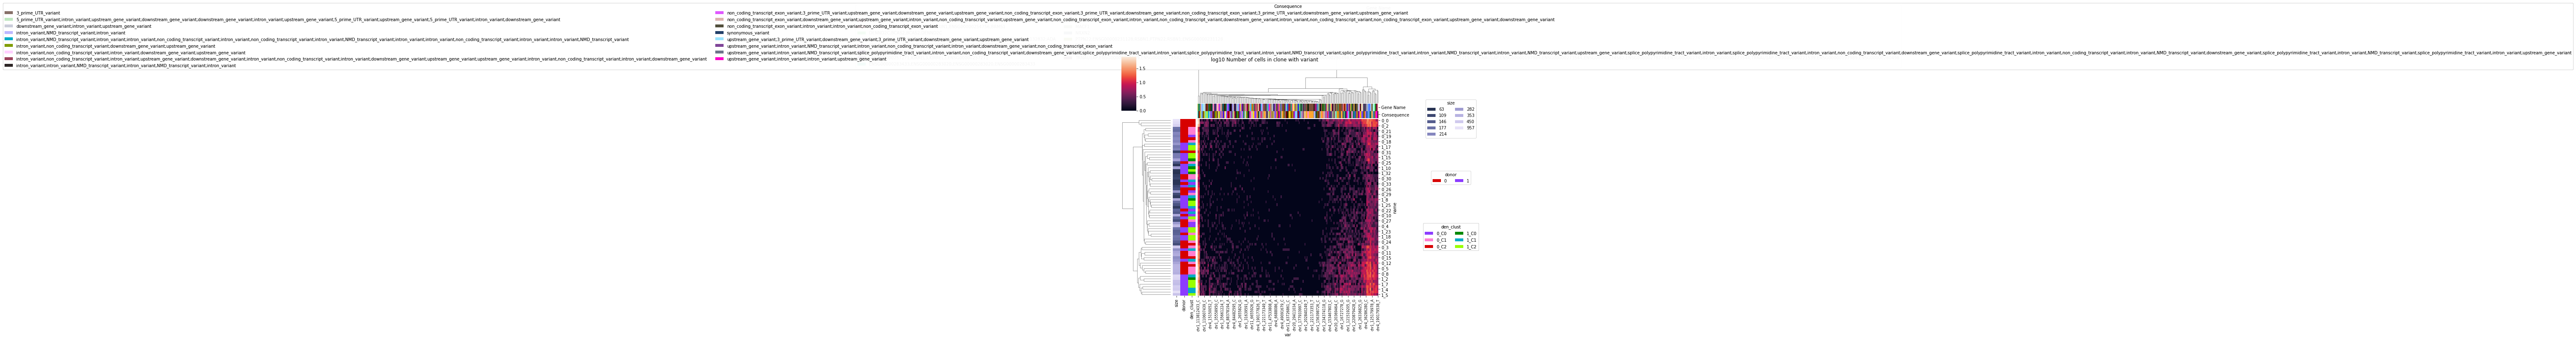

In [25]:
ch.plot_cluster(np.log10(clone_som_merge_df+1), col_meta=clone_som_vars_df_rmdups,row_meta=clones, 
                col_clr_schemes='categorical',
                row_clr_schemes={"size":"sequential", "den_clust": "categorical", "donor":"categorical"})
plt.suptitle("log10 Number of cells in clone with variant")
fu.helper_save(join(outdir, "som_vars_dendro.png"), to_pdf=False)

In [26]:
outdir

'/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/somatic_variants/gatk_mutect/peaks_atac_peaks/filt_chip/som_dendro_0.6'

## A2. With variants

## Split by donor

d 0
curr_som (34, 161)
Using only 16 of the labels for legend
Using only 16 of the labels for legend
d 1
curr_som (33, 162)
Using only 16 of the labels for legend
Using only 16 of the labels for legend


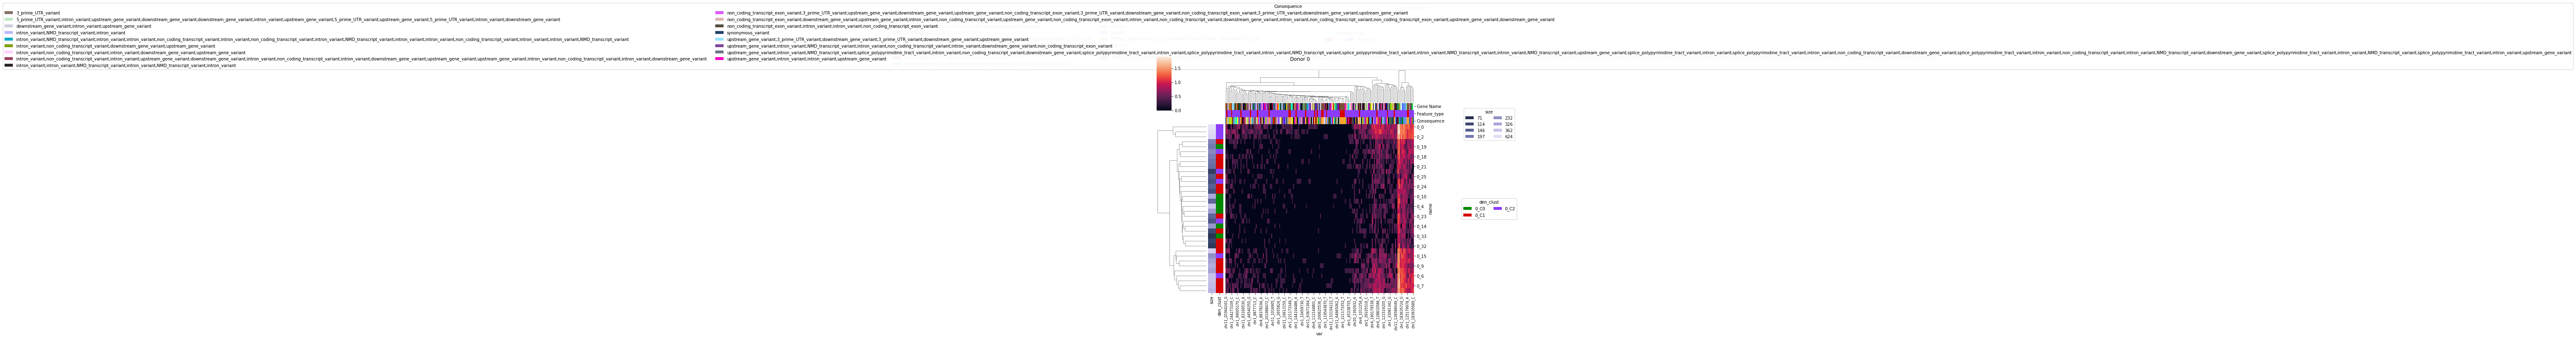

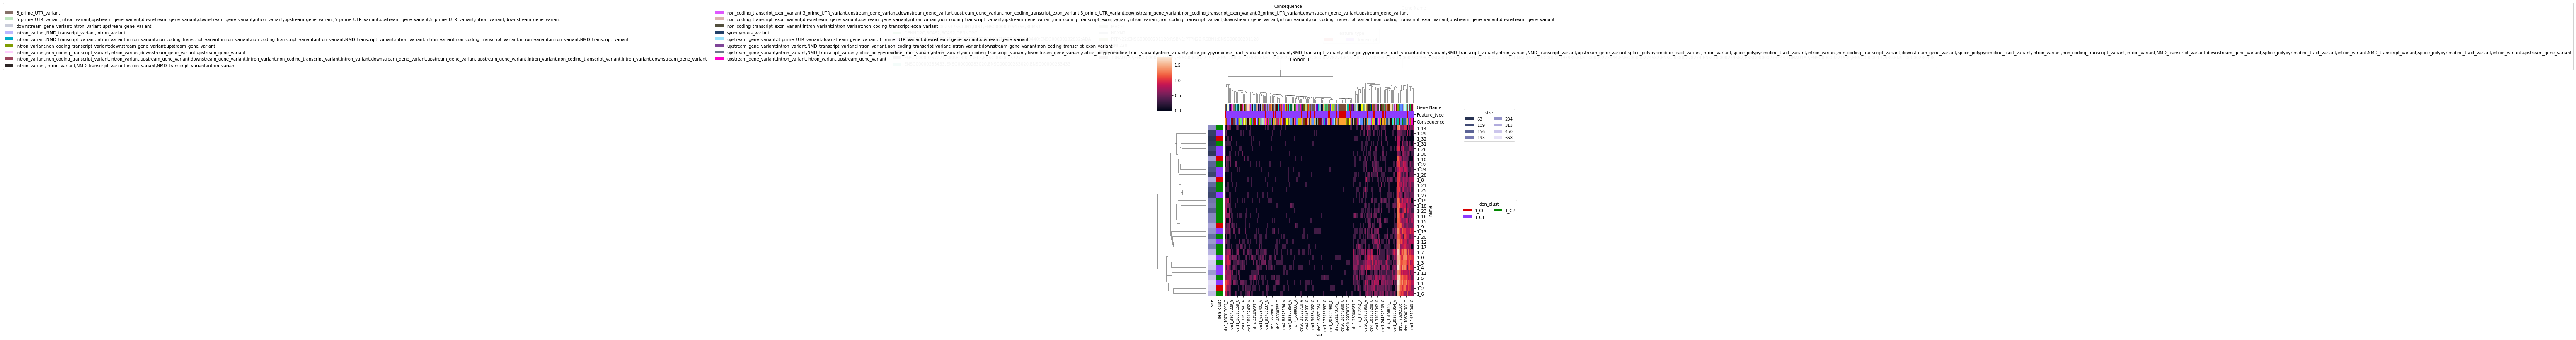

In [16]:
for d, curr_cl in clones.groupby("donor"):
    print('d', d)
    curr_som = clone_som_merge_df.loc[clone_som_merge_df.index.isin(curr_cl.index)]
    curr_som = curr_som.loc[:, ~((curr_som==0).all())]
    print('curr_som', curr_som.shape)
    if curr_som.shape[0] == 1:
        f = plt.figure()
        sns.heatmap(np.log10(curr_som+1))
    else:
        sampled_vars = curr_som.sample(n=min(1000,curr_som.shape[1]),axis=1).columns
        ch.plot_cluster(np.log10(curr_som.loc[:,sampled_vars]+1), col_meta=clone_som_vars_df_rmdups,
                        row_meta=curr_cl.drop("donor",axis=1), 
                        col_clr_schemes='categorical', 
                        row_clr_schemes={"size":"sequential", "den_clust": "categorical", "donor":"categorical"})

    plt.suptitle(f"Donor {d}")
    fu.helper_save(join(outdir, f"donor{d}_som_vars_dendro.png"), to_pdf=False)
    #fu.helper_save(join(outdir, f"donor{d}_som_vars_dendro.png"), to_pdf=False)

## Normalize to clone size

d 0
curr_som (34, 161)
Using only 16 of the labels for legend
Using only 16 of the labels for legend
d 1
curr_som (33, 162)
Using only 16 of the labels for legend
Using only 16 of the labels for legend


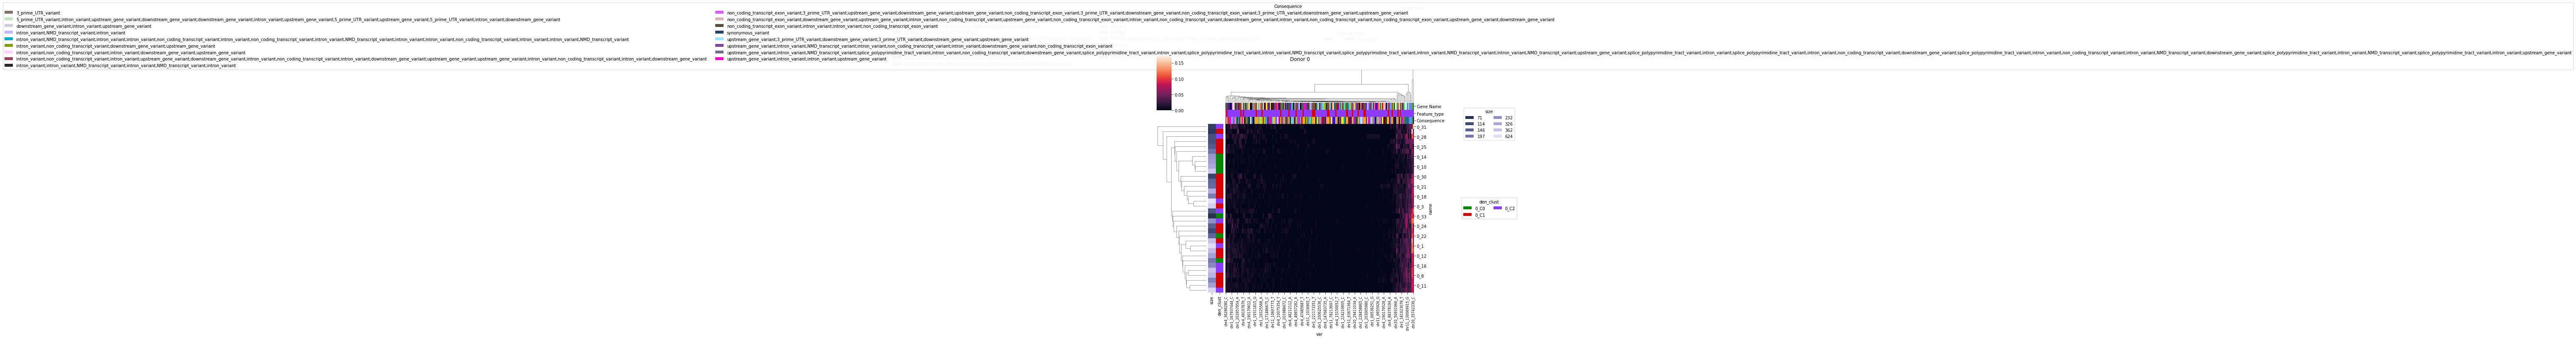

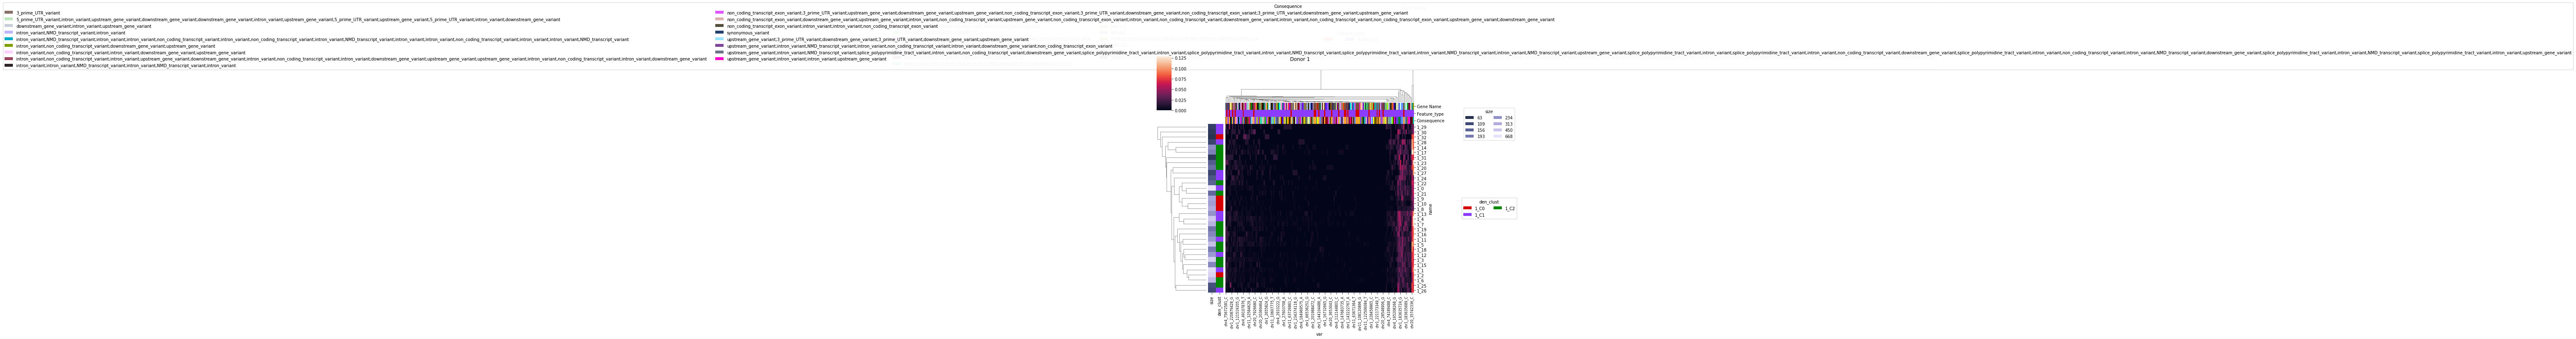

In [17]:
for d, curr_cl in clones.groupby("donor"):
    print('d', d)
    curr_som = clone_som_merge_df.loc[clone_som_merge_df.index.isin(curr_cl.index)]
    curr_som = curr_som.apply(lambda x: x/curr_cl.loc[x.name,"size"], axis=1)
    curr_som = curr_som.loc[:, ~((curr_som==0).all())]
    curr_som
    print('curr_som', curr_som.shape)
    if curr_som.shape[0] == 1:
        f = plt.figure()
        sns.heatmap(curr_som)
    else:
        sampled_vars = curr_som.sample(n=min(1000,curr_som.shape[1]),axis=1).columns
        ch.plot_cluster(curr_som.loc[:,sampled_vars], row_meta=curr_cl.drop("donor",axis=1),
                        row_clr_schemes={"size":"sequential", "den_clust": "categorical", "donor":"categorical"},
                        col_meta=clone_som_vars_df_rmdups, col_clr_schemes='categorical')

    plt.suptitle(f"Donor {d}")
    fu.helper_save(join(outdir, f"norm_donor{d}_som_vars_dendro.png"), to_pdf=False)